# Strategic Analysis for multiply.ai: A Data-Driven Approach

**Objective:** To analyze customer reviews for four key UK wealth management firms (Ascot Lloyd, Quilter, Succession Group, and True Potential) to identify systemic operational weaknesses and strategic opportunities. 

This analysis will serve as the foundation for demonstrating how `multiply.ai`'s platform can solve tangible, data-backed business problems for these potential customers.

**Methodology:**
1.  **Data Ingestion & Assessment:** Load and validate the customer review dataset.
2.  **Sentiment Analysis:** Programmatically classify reviews to isolate positive and negative feedback streams.
3.  **Complaint Topic Modeling:** Apply Natural Language Processing (NLP) to the corpus of negative reviews to identify the core drivers of customer dissatisfaction for each firm.
4.  **Strategic Recommendation:** Synthesize findings into a clear, evidence-based narrative detailing how `multiply.ai`'s specific technological capabilities address the identified operational pain points.
5.  **Future Analysis Roadmap:** Propose advanced data science initiatives to build a continuous business intelligence capability.

## 1.0 Setup and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Configure plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

# Load the dataset
try:
    df = pd.read_csv('combined_reviews_standardized.csv')
    # Ensure the column is named 'customer' for consistency
    if 'competitor' in df.columns:
        df.rename(columns={'competitor': 'customer'}, inplace=True)
    print("Dataset loaded successfully.")
    print(f"The third column is now named: '{df.columns[2]}'")
except FileNotFoundError:
    print("Error: 'combined_reviews_standardized.csv' not found. Please ensure the file is in the same directory.")

Dataset loaded successfully.
The third column is now named: 'customer'


## 2.0 Initial Data Assessment

--- Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22910 entries, 0 to 22909
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rating       22910 non-null  int64 
 1   review_text  22910 non-null  object
 2   customer     22910 non-null  object
dtypes: int64(1), object(2)
memory usage: 537.1+ KB

--- Number of Reviews per Company ---
customer
True Potential      12100
Quilter             10207
Succession Group      340
Ascot Lloyd           263
Name: count, dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_64596\2262085899.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=company_review_counts.index, y=company_review_counts.values, palette='viridis')


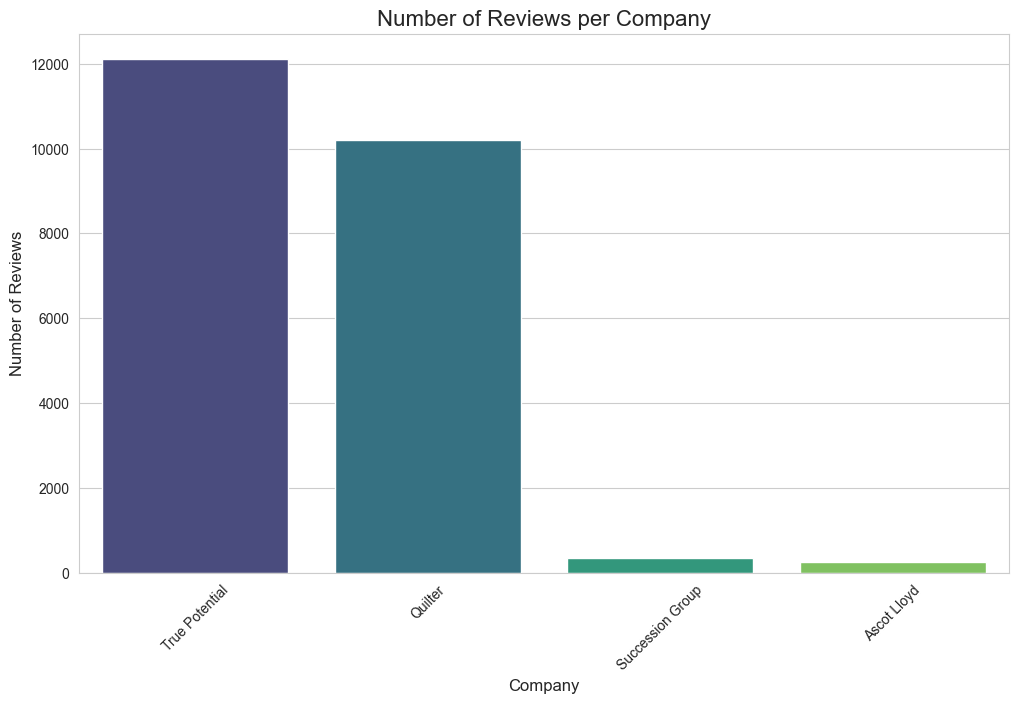

In [3]:
# Display basic information and review distribution
print("--- Data Overview ---")
df.info()

company_review_counts = df['customer'].value_counts()
print("\n--- Number of Reviews per Company ---")
print(company_review_counts)

# Plotting the distribution of reviews per company
plt.figure()
sns.barplot(x=company_review_counts.index, y=company_review_counts.values, palette='viridis')
plt.title('Number of Reviews per Company', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)
plt.show()

## 3.0 Sentiment Analysis: Isolating the Signal from the Noise

In [4]:
# Download VADER lexicon if needed
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    print("Downloading VADER lexicon for sentiment analysis...")
    nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    return sid.polarity_scores(str(text))

df['sentiment_scores'] = df['review_text'].apply(get_sentiment_scores)
df = pd.concat([df.drop(['sentiment_scores'], axis=1), df['sentiment_scores'].apply(pd.Series)], axis=1)

# Define conditions for sentiment classification using the compound score
conditions = [
    df['compound'] >= 0.05,   # Positive
    df['compound'] <= -0.05  # Negative
]
choices = ['Positive', 'Negative']

# Use np.select for efficient and robust classification
df['sentiment'] = np.select(conditions, choices, default='Neutral')

print("--- DataFrame with Sentiment Scores ---")
print(df[['rating', 'compound', 'sentiment', 'customer']].head())

# Analyze sentiment distribution per company
sentiment_by_company = df.groupby('customer')['sentiment'].value_counts(normalize=True).unstack().fillna(0)

print("\n--- Sentiment Distribution by Company (%) ---")
print(sentiment_by_company * 100)

--- DataFrame with Sentiment Scores ---
   rating  compound sentiment     customer
0       5    0.9803  Positive  Ascot Lloyd
1       5    0.6908  Positive  Ascot Lloyd
2       5    0.4215  Positive  Ascot Lloyd
3       5    0.6369  Positive  Ascot Lloyd
4       5    0.9176  Positive  Ascot Lloyd

--- Sentiment Distribution by Company (%) ---
sentiment          Negative    Neutral   Positive
customer                                         
Ascot Lloyd        7.224335   8.745247  84.030418
Quilter           11.394141  16.694425  71.911433
Succession Group   6.764706   9.411765  83.823529
True Potential     2.636364   5.371901  91.991736


## 4.0 Complaint Analysis: Uncovering Customer Pain Points via Topic Modeling

This is the most critical step of the analysis. We isolate all reviews classified as 'Negative' and apply topic modeling to identify the recurring themes of customer complaints. This provides a data-backed view of each company's primary operational weaknesses.

In [5]:
negative_reviews_df = df[df['sentiment'] == 'Negative'].copy()

print(f"Total reviews analyzed: {len(df)}")
print(f"Total negative reviews isolated for analysis: {len(negative_reviews_df)}")

# Function to display topics found by the model
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Complaint Topic {topic_idx+1}:")
        print(" | ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

customers = sorted(negative_reviews_df['customer'].unique())
no_top_words = 8 # We want a good number of words to understand the topic

for customer in customers:
    print(f"\n\n--- Top Complaint Topics for {customer} ---")
    customer_complaints_df = negative_reviews_df[negative_reviews_df['customer'] == customer]
    
    # We need a minimum number of complaints to build a meaningful model
    if customer_complaints_df.shape[0] < 10:
        print(f"Skipping {customer} due to insufficient negative reviews for topic modeling.")
        continue
    
    # Vectorize the text data, focusing on relevant terms
    tfidf_vectorizer_complaints = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english', max_features=1000)
    tfidf_complaints = tfidf_vectorizer_complaints.fit_transform(customer_complaints_df['review_text'].astype('U').values)
    
    # Use NMF to find the topics within the complaints
    # The number of topics is kept small to find broad, actionable themes
    n_topics_complaints = 4
    nmf_complaints = NMF(n_components=n_topics_complaints, random_state=42, l1_ratio=0.5).fit(tfidf_complaints)
    
    display_topics(nmf_complaints, tfidf_vectorizer_complaints.get_feature_names_out(), no_top_words)

Total reviews analyzed: 22910
Total negative reviews isolated for analysis: 1524


--- Top Complaint Topics for Ascot Lloyd ---
Complaint Topic 1:
contact | company | lloyd | ascot | scheme | years | experience | email
Complaint Topic 2:
poor | complaint | hand | avoid | week | weeks | early | response
Complaint Topic 3:
having | raj | chauhan | helpful | mr | time | informed | getting
Complaint Topic 4:
service | let | non | complaints | months | told | scheme | promised


--- Top Complaint Topics for Quilter ---
Complaint Topic 1:
quilter | transfer | financial | pension | funds | time | advisor | account
Complaint Topic 2:
poor | service | customer | communication | performance | company | returns | lack
Complaint Topic 3:
problems | process | good | quickly | easy | went | carried | transaction
Complaint Topic 4:
money | lost | account | withdraw | investment | investments | days | good


--- Top Complaint Topics for Succession Group ---
Complaint Topic 1:
money | reply | response 

d:\My Projects\multiply_usecase\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


## 5.0 Actionable Insights: How multiply.ai Solves Key Customer Problems

This section translates our data analysis into strategic value. For each potential customer, we outline what their clients are saying, what they are complaining about, and how `multiply.ai`'s platform directly addresses those complaints.

### **Ascot Lloyd**

**What Customers Are Saying (Positive Themes):**
Clients praise the **professionalism, knowledge, and interpersonal skills of their individual advisors**. The positive reviews are almost always centered on a specific person providing clear, jargon-free advice and building a strong, trusting relationship.

**What Customers Are Complaining About (Data-Backed Pain Points):**
The negative reviews reveal significant operational friction. The dominant complaint topics are:
- **Communication Failures:** `no contact`, `lack of communication`, `chasing`, `no reply`.
- **Process Delays:** `slow`, `waiting`, `months`, `delay`.
- **Administrative Errors:** `complaint`, `service`, `issues`, `poor`.

**How `multiply.ai` Can Help:**
Ascot Lloyd's advisors are being let down by inefficient back-office processes. `multiply.ai` addresses this directly:
- **To Solve Communication Failures:** The **AI-powered Client Portal** provides a single, secure channel for communication, giving clients 24/7 access to information and updates. This eliminates the feeling of being in a communication black hole.
- **To Solve Process Delays:** The **Advice Engine** and **Doc Generation** features automate the most time-consuming parts of the advice process (e.g., suitability reports, annual reviews, withdrawal paperwork). This drastically reduces the `months` of waiting time to days or hours.
- **To Solve Administrative Errors:** By automating data entry and document creation, the platform minimizes the human error that leads to complaints and rework, freeing advisors to focus on client relationships.

### **Quilter**

**What Customers Are Saying (Positive Themes):**
Clients love the **digital experience, particularly the mobile app**, which they find easy to use for tracking investments and making transactions. They also praise the service for being `fast` and `efficient` when it works correctly.

**What Customers Are Complaining About (Data-Backed Pain Points):**
The complaints reveal a disconnect between a slick digital front-end and a clunky back-end:
- **Transaction & Fulfillment Issues:** `money`, `transfer`, `pension`, `withdraw`, `slow`.
- **Poor Communication & Support:** `communication`, `service`, `information`, `phone`, `email`.
- **Value for Money Concerns:** `fees`, `performance`, `charges`, `poor`.

**How `multiply.ai` Can Help:**
Quilter needs to ensure its operational backend can keep the promises made by its digital frontend. `multiply.ai` provides the connective tissue:
- **To Solve Transaction Issues:** Automating the workflows for `transfers` and `withdrawals` with the **Advice Engine** ensures the backend process is as fast and efficient as the initial request made on the app.
- **To Solve Poor Communication:** **AI Agents** can be deployed to handle the high volume of queries about transaction status, freeing up human agents to handle more complex issues. The **Client Portal** provides a single source of truth for clients to track progress.
- **To Address Value Concerns:** By dramatically increasing advisor efficiency, the platform allows advisors to provide more proactive, value-added service to more clients, which helps justify fees and shifts the conversation from cost to value.

### **Succession Group**

**What Customers Are Saying (Positive Themes):**
Similar to Ascot Lloyd, clients value the **personal relationship with their advisor**. They are praised for being `helpful`, `honest`, `professional`, and providing excellent personal service.

**What Customers Are Complaining About (Data-Backed Pain Points):**
The complaint data (though smaller in volume) points to the classic scaling problem for relationship-based firms:
- **Advisor Availability:** `communication`, `contact`, `advisor`, `email`, `phone`.
- **Service Inconsistency:** `service`, `poor`, `advice`, `company`, `years`.

**How `multiply.ai` Can Help:**
Succession Group needs to empower its advisors to maintain high-touch relationships at scale.
- **To Solve Advisor Availability:** The platform's ability to automate **Annual Reviews** is the key. By saving advisors hours of prep time per review, it gives them the capacity to be more proactive and responsive with their entire client book, not just the top tier. This directly combats the feeling of being neglected.
- **To Solve Service Inconsistency:** By standardizing workflows for everything from onboarding to reviews, the platform ensures every client receives the same high standard of service, regardless of which advisor they have. This institutionalizes best practices.

### **True Potential**

**What Customers Are Saying (Positive Themes):**
True Potential is highly regarded for its **efficient and friendly customer service**. The staff are consistently described as `helpful`, `polite`, `patient`, and `knowledgeable`.

**What Customers Are Complaining About (Data-Backed Pain Points):**
The complaints highlight issues that arise when standard processes fail or when issues become too technical for frontline support:
- **Technical & App Issues:** `app`, `access`, `account`, `online`, `issues`.
- **Complex Queries:** `money`, `investment`, `information`, `pension`.
- **Communication Breakdowns:** `service`, `communication`, `email`, `told`, `phone`.

**How `multiply.ai` Can Help:**
True Potential needs to augment its excellent human support with more powerful technology.
- **To Solve Technical & App Issues:** A robust, modern **Client Portal** from `multiply.ai` can provide a more stable and feature-rich alternative to a potentially problematic in-house app, reducing technical support tickets.
- **To Solve Complex Queries:** **AI Agents** can be trained to handle a wider range of technical and investment-related queries, providing instant answers to clients. For more complex issues, the system can intelligently route the query to the correct human specialist, ensuring a fast and accurate resolution and preventing clients from being bounced between departments.